### Description

Our intention is to take first steps towards developing an algorithm that could be used as part of a mobile or web app. At the end of this project, code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed else it would just give out saying error message that its unable to detect.


### Step 1 : Count images in Dataset

In [93]:
# The purpose of this step is to get a count of total number of images

import numpy as np
from glob import glob

dog_files = np.array(glob("dogimages/*/*/*"))
print('There are %d total dog images.' % len(dog_files))
dog_files_short = dog_files[:100]

There are 8351 total dog images.


### Step 2 : Fetch Absolute Path

In [94]:
# This step gets the absolute path of the directiories for training, validation and testing dataset
# Furthermore, we are specifying the batch size and number of worker required by the pytorch

import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


batch_size = 20
num_workers = 0

data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

### Step 3 : Normalization

- Normalization helps get data within a range and reduces the skewness which helps learn faster and better. 
- Normalization can also tackle the diminishing and exploding gradients problems.
- We are considering the mean and std of Imagenet as it is a common practice is a common practice. They are calculated based on millions of images.

In [95]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

### Step 4 : Declare Transformations

- For training data RandomResizedCrop & RandomHorizontalFlip
- This will do both image augmentations and resizing jobs. 
- Image augmentation will give randomness to the dataset so, it prevents overfitting and we can expect better performance of model when it's predicting toward test_data. 
- For the validation data only Resize of (256) and then, center crop to make 224 X 224 is needed as it cannot be untrue
- For the testing data only resize is possible as any alteration is not permitted


In [96]:
#  Specifying the data transforms as a dictionary.

data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

### Step 5 : Creating the instances of dataset after applying transformation

In [97]:

train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

### Step 6 : Using the dataset instance to create dataloaders and a dictionary containing them

- PyTorch systems utilizes PyTorch Dataset and DataLoader interfaces to serve up training or test data. 
- A Dataset object loads training or test data into memory and a DataLoader object fetches data from a Dataset and serves the data up in batches.

In [98]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

### Step 7 : Train the Dataset using transfer learning

- This will download the resnet50 a type of CNN supported by Pytorch some other options can be
- VGG, ResNet, SqueezeNet, DenseNet, Inception v3 etc
- The choice of ResNet was more of exploratory rather then any specific reason

In [99]:
import torchvision.models as models
import torch.nn as nn

# Specifying pretained as true assigns random weights to it
model_transfer = models.resnet50(pretrained=True)

### Step 9 : Configure the downloaded neural network

- requires_grad is set to true as we need to calculate the Gradient for the inital layers

In [100]:
for param in model_transfer.parameters():
    param.requires_grad = False

### Step 10 : Specifying classifier

- Specifying the fully connected layer
- Resnet50 has 1000 classes we are limiting it to 133 in the final layer
- The input features are set to 2048

In [101]:
model_transfer.fc = nn.Linear(2048, 133, bias=True)

### Step 11 : Setting requires_grad for each parameters of classifier to True

- requires_grad is set to true as we need to calculate the Gradient for this layer

In [102]:
fc_parameters = model_transfer.fc.parameters()

In [103]:
for param in fc_parameters:
    param.requires_grad = True

model_transfer

### Step 12 : Checking if cuda is available on the system

In [104]:
use_cuda = torch.cuda.is_available()
print("cuda available? {0}".format(use_cuda))

if use_cuda:
    model_transfer = model_transfer.cuda()

cuda available? True


### Step 13 : Specifying the Activation function and Optimizers for the classifier

- Criterion refers to the type of Loss function used

In [75]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### Step 14 : Defining the training method

In [76]:

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        valid_loss = 0.0
        
        # TRAIN THE MODEL
        model.train()
        
        # Batch index is the iterative index created by ennumerating the training loader         
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculating loss
            # Criterion refers to the Loss function used
            loss = criterion(output, target)
            
            # back propogation
            loss.backward()
            
            # grad descent
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        
        # VALIDATE THE MODEL
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [77]:
train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'saved_models/model_transfer.pt')

Epoch 1, Batch 1 loss: 4.953734
Epoch 1, Batch 101 loss: 4.891730
Epoch 1, Batch 201 loss: 4.852574
Epoch 1, Batch 301 loss: 4.816188
Epoch: 1 	Training Loss: 4.805253 	Validation Loss: 4.625626
Validation loss decreased (inf --> 4.625626).  Saving model ...
Epoch 2, Batch 1 loss: 4.732060
Epoch 2, Batch 101 loss: 4.646194
Epoch 2, Batch 201 loss: 4.621096
Epoch 2, Batch 301 loss: 4.592752
Epoch: 2 	Training Loss: 4.582110 	Validation Loss: 4.377141
Validation loss decreased (4.625626 --> 4.377141).  Saving model ...
Epoch 3, Batch 1 loss: 4.620346
Epoch 3, Batch 101 loss: 4.449503
Epoch 3, Batch 201 loss: 4.424760
Epoch 3, Batch 301 loss: 4.396337
Epoch: 3 	Training Loss: 4.388694 	Validation Loss: 4.135761
Validation loss decreased (4.377141 --> 4.135761).  Saving model ...
Epoch 4, Batch 1 loss: 4.280138
Epoch 4, Batch 101 loss: 4.256617
Epoch 4, Batch 201 loss: 4.239642
Epoch 4, Batch 301 loss: 4.216025
Epoch: 4 	Training Loss: 4.207480 	Validation Loss: 3.917742
Validation loss de

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Step 15 : Transferring the trained model to file

In [78]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('saved_models/model_transfer.pt'))

<All keys matched successfully>

### Step 16 : Testing the trained model

In [79]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [80]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.821758


Test Accuracy: 72% (603/836)


### Step 17 : Refining the class names

In [81]:

class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

In [82]:
loaders_transfer['train'].dataset.classes[:10]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog']

In [83]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

### Step 18 : Creating method to process the input image

In [84]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

### Step 19 : Creating method return the index of the class names

In [85]:
def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [86]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    predition = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))

image_file_name: ./images\n02085936_137.jpg, 	 predition breed: Maltese
image_file_name: ./images\n02086646_20.jpg, 	 predition breed: Cavalier king charles spaniel


### Step 20 : Creating the main application method

In [87]:
import matplotlib.pyplot as plt      

In [90]:

def run_app(img_path):
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    prediction = predict_breed_transfer(model_transfer, class_names, img_path)
    print("Dogs Detected!\nIt looks like a {0}".format(prediction))  

### Step 21 : Unit test for the application

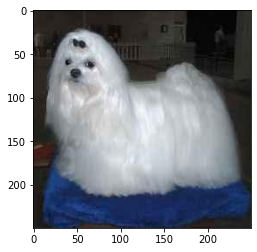

Dogs Detected!
It looks like a Maltese


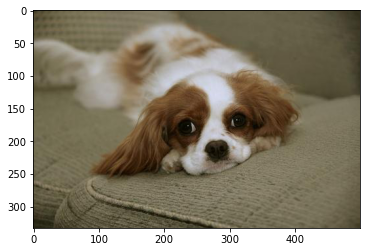

Dogs Detected!
It looks like a Cavalier king charles spaniel


In [91]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    run_app(img_path)